In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import os
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
np.random.seed(1)

In [0]:
import zipfile


zip_ref = zipfile.ZipFile("/content/drive/My Drive/MURA-v1.1.zip", 'r')
zip_ref.extractall("/tmp/SML")
zip_ref.close()

In [0]:
path = "/tmp/SML/MURA-v1.1"
csv_path = path+"/train_image_paths.csv"
df = pd.read_csv(csv_path,
                 names=["x_col"])
df['Region'] = df["x_col"].map(lambda x: x.split('/')[-4])
df["Region"] = df["Region"].map(lambda x: x.split('XR_')[-1])
df["y_col"] = df["x_col"].map(lambda x: x.split('/')[-2])
df["y_col"] = df["y_col"].map(lambda x: x.split('_')[-1])
df

,x_col,Region,y_col
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,positive
...,...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,HAND,negative
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,HAND,negative
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,HAND,negative
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,HAND,negative


In [0]:
# Can be done similarly for each body part
df = df[df["Region"]=="HUMERUS"]
df

,x_col,Region,y_col
8379,MURA-v1.1/train/XR_HUMERUS/patient02695/study1...,HUMERUS,positive
8380,MURA-v1.1/train/XR_HUMERUS/patient02626/study1...,HUMERUS,positive
8381,MURA-v1.1/train/XR_HUMERUS/patient02626/study1...,HUMERUS,positive
8382,MURA-v1.1/train/XR_HUMERUS/patient02696/study1...,HUMERUS,positive
8383,MURA-v1.1/train/XR_HUMERUS/patient02696/study1...,HUMERUS,positive
...,...,...,...
9646,MURA-v1.1/train/XR_HUMERUS/patient03224/study1...,HUMERUS,negative
9647,MURA-v1.1/train/XR_HUMERUS/patient03225/study1...,HUMERUS,negative
9648,MURA-v1.1/train/XR_HUMERUS/patient03225/study1...,HUMERUS,negative
9649,MURA-v1.1/train/XR_HUMERUS/patient03226/study1...,HUMERUS,negative


In [0]:

X = df["x_col"]
y = df["y_col"]

In [0]:
X_train_path, X_test_path, y_train, y_test = train_test_split(X, y, test_size = 0.20,stratify=y, random_state = 57)

In [0]:
df_train=pd.DataFrame()
df_valid = pd.DataFrame()
df_train["x_col"]=X_train_path
df_train["y_col"]=y_train
df_valid["x_col"]=X_test_path
df_valid["y_col"]=y_test

In [0]:
df_train['x_col']

9088    MURA-v1.1/train/XR_HUMERUS/patient02989/study1...
8846    MURA-v1.1/train/XR_HUMERUS/patient02883/study1...
8670    MURA-v1.1/train/XR_HUMERUS/patient02813/study1...
9380    MURA-v1.1/train/XR_HUMERUS/patient03102/study1...
8889    MURA-v1.1/train/XR_HUMERUS/patient02901/study1...
                              ...                        
9299    MURA-v1.1/train/XR_HUMERUS/patient03066/study1...
8769    MURA-v1.1/train/XR_HUMERUS/patient02852/study1...
8825    MURA-v1.1/train/XR_HUMERUS/patient02874/study1...
8534    MURA-v1.1/train/XR_HUMERUS/patient02757/study1...
9534    MURA-v1.1/train/XR_HUMERUS/patient03169/study1...
Name: x_col, Length: 1017, dtype: object

In [0]:
from keras.applications.resnet import ResNet152, preprocess_input
#from keras.applications.densenet import DenseNet169, preprocess_input
from keras.optimizers import Adam
from keras.models import Model
#DATASET_PATH  = "/content/drive/My Drive/Colab Notebooks"
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 2
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 10
WEIGHTS_FINAL = 'ResNet_CMAP_Humerus.h5'


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True)

train_batches = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory='/tmp/SML',
        x_col="x_col",
        y_col="y_col",
        interpolation='bicubic',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True)


# train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='binary',
#                                                   shuffle=True,
#                                                   batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_batches = valid_datagen.flow_from_dataframe(
        dataframe=df_valid,
        directory='/tmp/SML',
        x_col="x_col",
        y_col="y_col",
        target_size=IMAGE_SIZE,
        interpolation='bicubic',
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False)

# valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='binary',
#                                                   shuffle=False,
#                                                   batch_size=BATCH_SIZE)

# show class indices
print('******')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('******')

# build our classifier model based on pre-trained ResNet50:
# 1. we don't include the top (fully connected) layers of ResNet50
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')
net = ResNet152(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid', name='sigmoid')(x)
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])
print(net_final.summary())

# train the model
history=net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# save trained weights
net_final.save(WEIGHTS_FINAL)

Found 1017 validated image filenames belonging to 2 classes.
Found 255 validated image filenames belonging to 2 classes.
******
Class #0 = negative
Class #1 = positive
******
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchN

In [0]:
activation_layer = net_final.get_layer('conv5_block3_out')

In [0]:
model = Model(inputs=net_final.input, outputs=activation_layer.output)

In [0]:
final_dense = net_final.get_layer('sigmoid')

In [0]:
W = final_dense.get_weights()[0]
W

array([[ 0.04280584],
       [-0.03887377],
       [ 0.03659899],
       ...,
       [-0.02561144],
       [-0.0225984 ],
       [ 0.03569132]], dtype=float32)

In [0]:
image_files = df_test['x_col']
image_files1=[]
for img in image_files:
  image_files1.append("/tmp/SML/"+img)


In [0]:
from keras.applications.resnet50 import decode_predictions
import scipy as sp

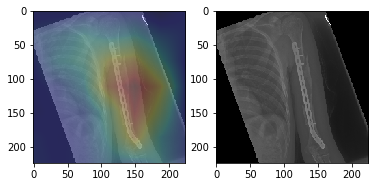

Continue Y/Ny


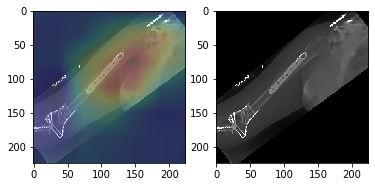

Continue Y/Ny


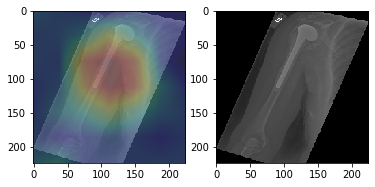

Continue Y/Ny


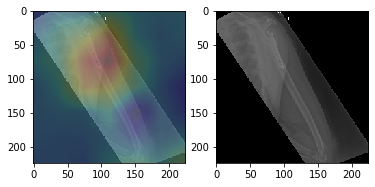

In [0]:
while True:
  img = image.load_img(np.random.choice(image_files1), target_size=(224,224))
  x = preprocess_input(np.expand_dims(img,0))
  fmaps = model.predict(x)[0]

  probs = net_final.predict(x)
  # classnames = decode_predictions(probs)
  # print(classnames)
  # classname = classnames[0][1]
  pred = np.argmax(probs[0])

  w = W[:,pred]
  cam = fmaps.dot(w)
  
  cam = sp.ndimage.zoom(cam, (32,32), order=1)

  plt.subplot(1,2,1)
  plt.imshow(img, alpha=0.8)
  plt.imshow(cam, cmap='jet', alpha =0.2)
  plt.subplot(1,2,2)
  plt.imshow(img)
  # plt.title(classname)
  plt.show()

  ans = input("Continue Y/N")
  if ans and ans[0].lower() == 'n':
    break